# Sentiment Analysis and Hate-Speech Detection on Tweets

Todo Naive Bayes: 
- Perform hyperparameter tuning? 

In [1]:
import pandas as pd
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from helper_functions import *
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


## Sentiment Data EDA

In [2]:
df_sentiment=pd.read_csv('data/Sentiment140.csv', encoding='latin-1', header=None, index_col=False)
df_sentiment = df_sentiment[[0, 5]].rename(columns={0: "target", 5: "text"})
df_sentiment.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
df_sentiment.isnull().sum()

target    0
text      0
dtype: int64

In [4]:
# output the dataframe structure
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


<AxesSubplot: >

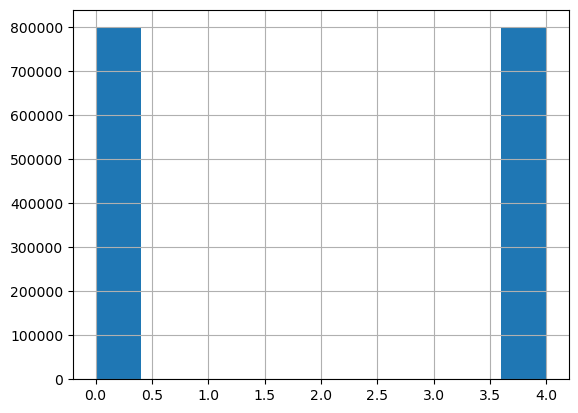

In [5]:
#Convert target to categorical
df_sentiment['target'] = pd.Categorical(df_sentiment.target)
df_sentiment['target'].unique()
df_sentiment['target'].hist()

In this dataset, target values describe the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive). However, there are only negative and positive tags (0 and 4) so let's change those values to 0 = negative, 1 = positive

<AxesSubplot: >

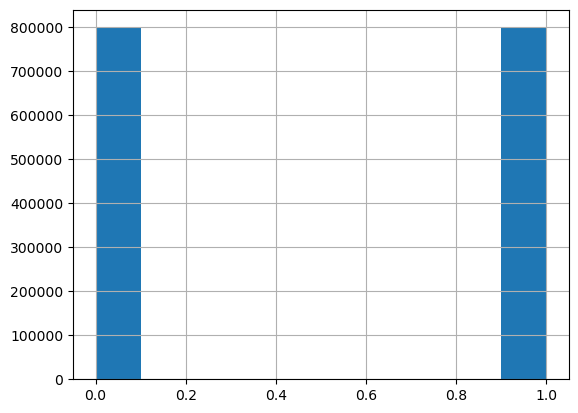

In [6]:
df_sentiment['target'] = df_sentiment['target'].replace(4,1) #Replace 4 (positive) by 1. Negative (0) remain the same
df_sentiment['target'].hist()

<AxesSubplot: >

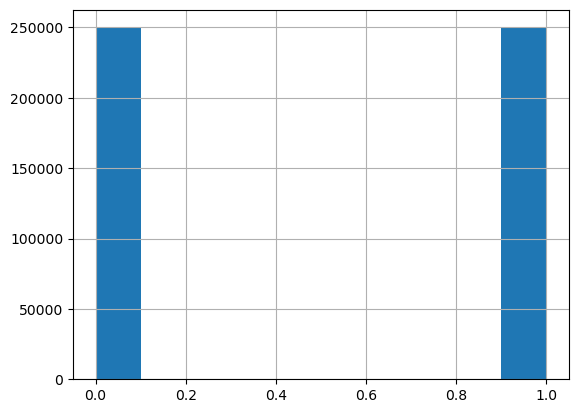

In [7]:
# For testing purposes, get a sample of the data
df_sentiment=df_sentiment.sample(500000)
df_sentiment['target'].hist()

## Hate Speech Data EDA

In [8]:
df_hate=pd.read_csv('data/HateSpeech_tweets.csv', encoding='latin-1', usecols  = ["class", "tweet"])
df_hate = df_hate.rename(columns={"class": "target", "tweet": "text"})
df_hate.head()

,target,text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
df_hate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  24783 non-null  int64 
 1   text    24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [10]:
df_hate.isnull().sum()

target    0
text      0
dtype: int64

<AxesSubplot: >

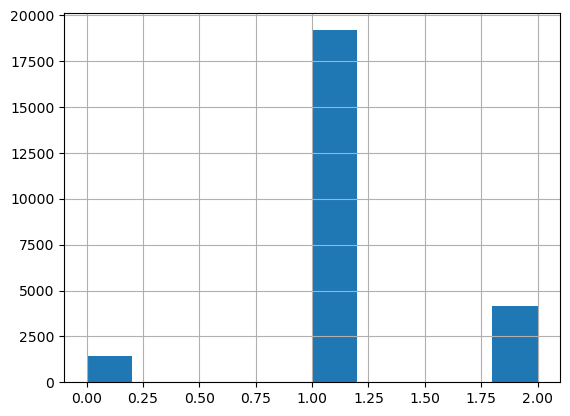

In [11]:
#Convert target to categorical
df_hate['target'] = pd.Categorical(df_hate.target)
df_hate['target'].unique()
df_hate['target'].hist()

UPDATE THIS IF WE ARE FINALLY KEEPING NON_OFFENSIVE TWEETS
In this dataset, target values describe the type of the tweet (0 - hate speech, 1 - offensive language, 2 - neither). However, for the desired task we are only interested in retrieving the hate speech and offensive language and identify a Negative Sentiment. Thus, we will remove the non-offensive text rows (tagged as 2-neither) and combine hate speech (0) and offensive language (1) into the same category 0, which is the value we used when traning the model to tag a Negative sentiment.

<AxesSubplot: >

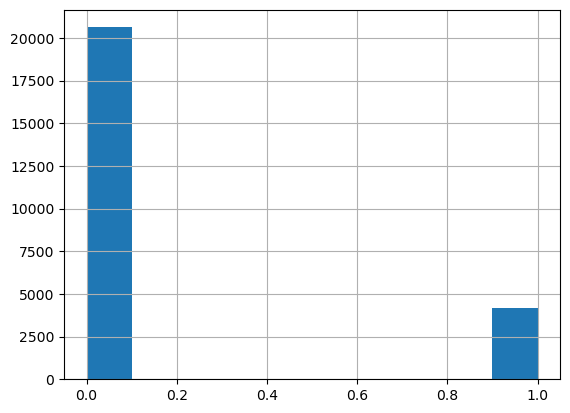

In [12]:
df_hate['target'] = df_hate['target'].replace(1,0) #Replace 1 (positive) by 0 to group hate speech and offensive language teweet into the same category
df_hate['target'] = df_hate['target'].replace(2,1) #Replace 1 (positive) by 0 to group hate speech and offensive language teweet into the same category
#df_hate = df_hate[df_hate['target'] == 0] #Keep only the rows with hate/offensive tweets
df_hate['target'].hist()

In [13]:
# Separate text from labels
X_hate=df_hate['text']
y_hate=df_hate['target']

## Train/ Test Split: Sentiment Data

In [14]:
# Split in training set and, testing set and separate labels from data
X_sentiment=df_sentiment['text']
y_sentiment=df_sentiment['target']

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Split in training set and, testing set and separate labels from data
X_train, X_test, y_train, y_test= train_test_split(X_sentiment, y_sentiment, test_size = 1 - train_ratio, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=validation_ratio/(test_ratio + validation_ratio), random_state = 0)

len(X_train), len(X_val), len(X_test)

(375000, 75000, 50000)

## Build Data Cleaning Pipeline

In [15]:
cleaning=[('cleaner', FunctionTransformer(data_cleaning))] #TODO Add stop words param
data_cleaning_pipeline=Pipeline(cleaning)

### Apply Data Cleaning Pipeline on Sentiment Data

In [16]:
t1 = time.time()

X_train_clean=data_cleaning_pipeline.fit_transform(X_train)

t2 = time.time()
print(t2 - t1)

33.89970898628235


In [17]:
t1 = time.time()

X_val_clean=data_cleaning_pipeline.fit_transform(X_val)

t2 = time.time()
print(t2 - t1)

6.677685022354126


In [18]:
t1 = time.time()

X_test_clean=data_cleaning_pipeline.fit_transform(X_test)

t2 = time.time()
print(t2 - t1)

4.497917890548706


### Apply Data Cleaning Pipeline on Hate Speech Data

In [19]:
t1 = time.time()

X_hate_clean=data_cleaning_pipeline.fit_transform(X_hate)

t2 = time.time()
print(t2 - t1)

2.2988967895507812


## Naive Bayes Model

### Preprocessing Sentiment Data

##### Build TFIDF pipeline

In [20]:
# Build TfidfVectorizer Pipeline
tfidf=[('vectorizer', TfidfVectorizer(max_features=100000, ngram_range=(1, 2)))] #TODO Check these values
tfidf_pipeline=Pipeline(tfidf)

##### Appply TFIDF pipeline on Sentiment Data

In [21]:
#Apply TFIDF pipeline to the training set
t1 = time.time()

X_train_transformed=tfidf_pipeline.fit_transform(X_train_clean)

t2 = time.time()
print(t2 - t1)

9.666570901870728


In [22]:
#Apply TFIDF pipeline to the validation set
t1 = time.time()

X_val_transformed=tfidf_pipeline.fit_transform(X_val_clean)

t2 = time.time()
print(t2 - t1)

1.9811038970947266


In [23]:
#Apply TFIDF pipeline to the test set
t1 = time.time()

X_test_transformed=tfidf_pipeline.transform(X_test_clean)

t2 = time.time()
print(t2 - t1)

0.8066728115081787


### Train Sentiment Model

In [24]:
# Create a Naive Bayes model and fit the training data
naive_bayes_model=MultinomialNB()
naive_bayes_model.fit(X_train_transformed, y_train)

MultinomialNB()

### Evaluate Sentiment Model

In [25]:
# Generate Predictions for Trin and Test sets
nb_train_pred = naive_bayes_model.predict(X_train_transformed)
nb_test_pred = naive_bayes_model.predict(X_test_transformed)
nb_val_pred = naive_bayes_model.predict(X_val_transformed)

Results: Naive Bayes Model - sentiment, training set
Accuracy: 0.8291253333333334
F1: 0.8272271354616049
Precision: 0.836487864461494
Recall: 0.8181692116505683

Results: Naive Bayes Model - sentiment, validation set
Accuracy: 0.5052266666666667
F1: 0.5228003394974409
Precision: 0.5052320234633261
Recall: 0.5416344693437075

Results: Naive Bayes Model - sentiment, testing set
Accuracy: 0.50292
F1: 0.5198408098605155
Precision: 0.5035179640718563
Recall: 0.537257407555307


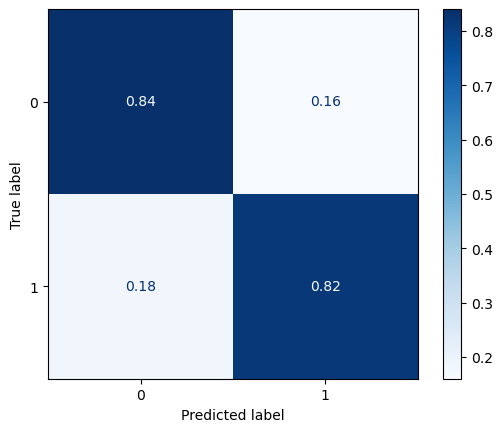

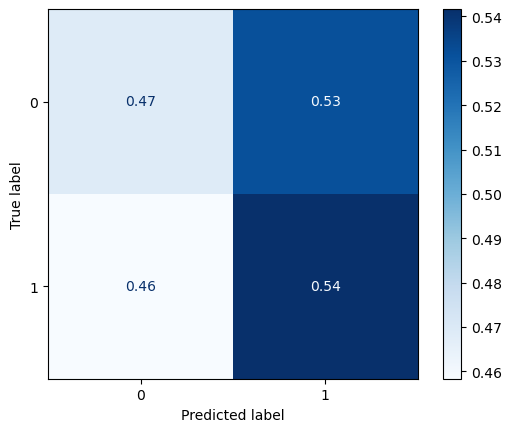

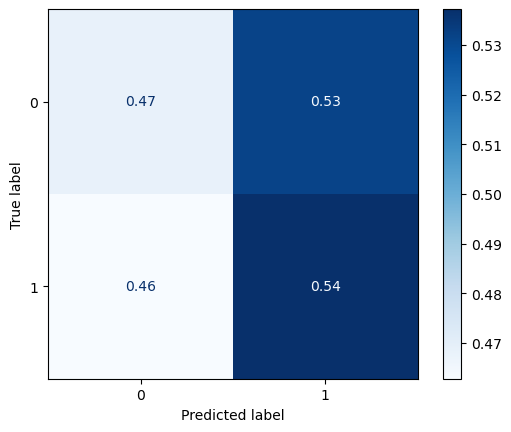

In [26]:
# Evaluate the Naive Bayes model
print("Results: Naive Bayes Model - sentiment, training set")
evaluate(y_train, nb_train_pred)
print()
print("Results: Naive Bayes Model - sentiment, validation set")
evaluate(y_val, nb_val_pred)
print()
print("Results: Naive Bayes Model - sentiment, testing set")
evaluate(y_test, nb_test_pred)

## Hate Speech Detection with Naive Bayes Model

In [27]:
#Apply TFIDF on Hate Speech data
t1 = time.time()

X_hate_transformed=tfidf_pipeline.transform(X_hate_clean)

t2 = time.time()
print(t2 - t1)

0.40361499786376953


In [28]:
# Generate predictions
t1 = time.time()

nb_hate_pred = naive_bayes_model.predict(X_hate_transformed)

t2 = time.time()
print(t2 - t1)

0.0027971267700195312


Accuracy: 0.49001331557922767
F1: 0.22654672296677072
Precision: 0.15199540154376745
Recall: 0.4446312755224598


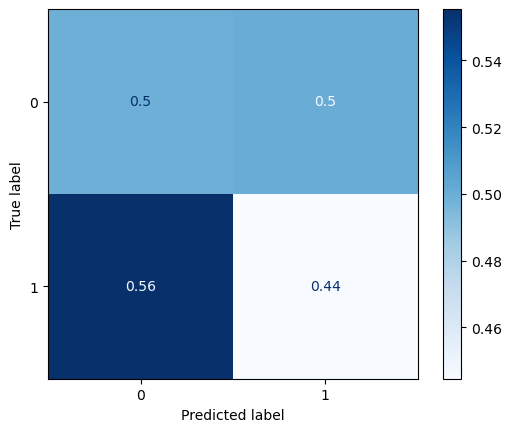

In [29]:
evaluate(y_hate, nb_hate_pred)

## LSTM 

In [30]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras import layers

### Preprocessing Sentiment Data

#### Preprocessing

In [31]:
tokenizer=Tokenizer() # change to the non-deprecated tf.keras.layers.TextVectorization 
tokenizer.fit_on_texts(X_train_clean)
vocab_size=len(tokenizer.word_index)+1
print(f'Vocab Size: {vocab_size}')

Vocab Size: 227234


In [32]:
def lstm_preprocessing(X, y, tokenizer, maxlen = 40):
    X_processed = pad_sequences(tokenizer.texts_to_sequences(X), maxlen)
    y_processed = to_categorical(y)
    return (X_processed, y_processed)

# Apply preprocessing to train and validation sets
X_train_processed, y_train_processed = lstm_preprocessing(X_train_clean, y_train, tokenizer)
X_val_processed, y_val_processed = lstm_preprocessing(X_val_clean, y_val, tokenizer)

### GLoVE Embedding

Download glove.twitter.27B from https://nlp.stanford.edu/projects/glove/

In [33]:
def get_embeddings_dict(file): 
    embeddings_dict = {}
    with open(file, 'r' , encoding="utf−8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_dict[word] = coefs
    return(embeddings_dict)

path_to_glove_file = "./data/glove.twitter.27B/glove.twitter.27B.50d.txt"
embeddings_dict = get_embeddings_dict(path_to_glove_file)

In [34]:
# Create embedding matrix
num_tokens = vocab_size
embedding_dim = 50
hits = 0 
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items(): 
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
        hits += 1
    else: 
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 74342 words (152891 misses)


### LSTM Model with GLoVE embeddings

#### Train

In [36]:
model_GLoVE=Sequential()
model_GLoVE.add(layers.Embedding(vocab_size, 50, weights=[embedding_matrix], input_length = 40, trainable=False))       
model_GLoVE.add(layers.Dropout(0.5)) #added dropout layer to address overfitting
model_GLoVE.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_GLoVE.add(layers.Dense(2,activation='sigmoid'))
model_GLoVE.compile(optimizer='adam',\
              loss='categorical_crossentropy',\
              metrics=['accuracy'])

model_GLoVE.summary()

history = model_GLoVE.fit(X_train_processed,\
              y_train_processed,\
              batch_size=256,\
              epochs=5,\
              validation_data=(X_val_processed,y_val_processed))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 50)            11361700  
                                                                 
 dropout_1 (Dropout)         (None, 40, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 11,422,302
Trainable params: 60,602
Non-trainable params: 11,361,700
_________________________________________________________________
Epoch 1/5
1465/1465 [==============================] - 96s 65ms/step - loss: 0.5838 - accuracy: 0.6865 - val_loss: 0.5265 - val_accuracy: 0.7355
Epoch 2/5
1465/1465 [===

#### Evaluate Sentiment Model

In [37]:
# Preprocess test data
X_test_processed, y_test_processed = lstm_preprocessing(X_test_clean, y_test, tokenizer)

In [38]:
# Generate predictions for sentiment data
predictions_sentiment = model_GLoVE.predict(X_test_processed)
predictions_sentiment = prediction_probs_to_target(predictions_sentiment)

1563/1563 [==============================] - 9s 5ms/step


Accuracy: 0.7668
F1: 0.7488908989102814
Precision: 0.81278047868362
Recall: 0.6943135532305726


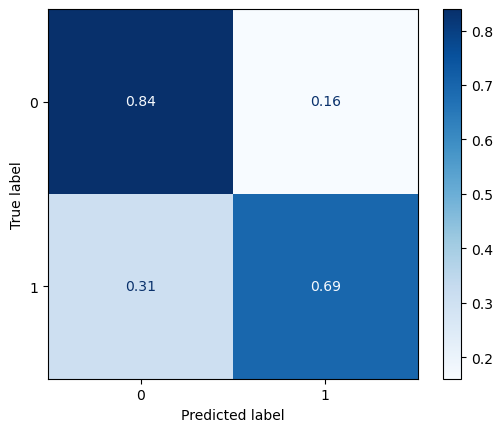

In [39]:
# Evaluate model on test data
evaluate(y_test, predictions_sentiment)

#### Hate Speech Detection with LSTM Model

In [40]:
X_hate_processed, y_hate_processed = lstm_preprocessing(X_hate_clean, y_hate, tokenizer)

In [41]:
predictions_hate = model_GLoVE.predict(X_hate_processed)
predictions_hate = prediction_probs_to_target(predictions_hate)

775/775 [==============================] - 4s 5ms/step


Accuracy: 0.5901222612274543
F1: 0.31632790415937545
Precision: 0.21972884525479197
Recall: 0.5644967571462888


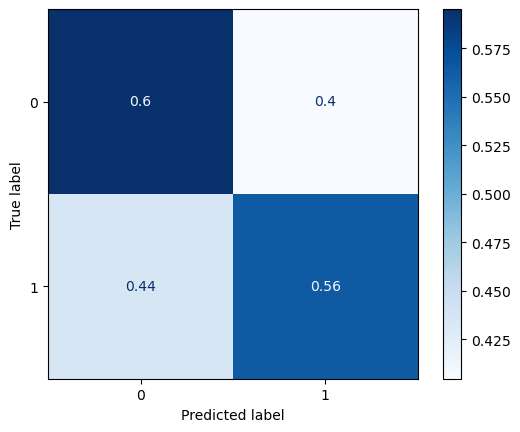

In [42]:
evaluate(y_hate, predictions_hate)

### Train Sentiment Model without GLoVE embeddings

#### Train

In [43]:
model=Sequential()
model.add(layers.Embedding(input_dim=vocab_size,\
                           output_dim=50,\
                           input_length=40)) 
model.add(layers.Dropout(0.5)) #added dropout layer to address overfitting
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2,activation='sigmoid'))
model.compile(optimizer='adam',\
              loss='categorical_crossentropy',\
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train_processed,\
              y_train_processed,\
              batch_size=256,\
              epochs=2,\
              validation_data=(X_val_processed,y_val_processed))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 50)            11361700  
                                                                 
 dropout_2 (Dropout)         (None, 40, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               60400     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 11,422,302
Trainable params: 11,422,302
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1465/1465 [==============================] - 149s 101ms/step - loss: 0.4728 - accuracy: 0.7740 - val_loss: 0.4328 - val_accuracy: 0.7988
Epoch 2/2
1465/1465 [======

#### Evaluate Sentiment Model

In [45]:
# Preprocess test data
X_test_processed, y_test_processed = lstm_preprocessing(X_test_clean, y_test, tokenizer)

In [46]:
# Generate predictions for sentiment data
predictions_sentiment = model.predict(X_test_processed)
predictions_sentiment = prediction_probs_to_target(predictions_sentiment)

1563/1563 [==============================] - 9s 5ms/step


Accuracy: 0.80262
F1: 0.8026791962411276
Precision: 0.8037880911384295
Recall: 0.8015733567606421


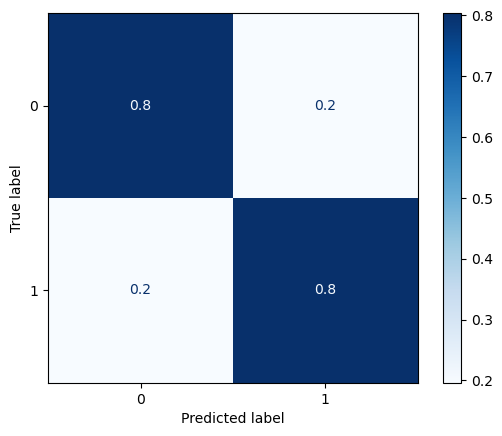

In [47]:
# Evaluate model on test data
evaluate(y_test, predictions_sentiment)

#### Hate Speech Detection with LSTM Model

In [51]:
X_hate_processed, y_hate_processed = lstm_preprocessing(X_hate_clean, y_hate, tokenizer)

In [52]:
predictions_hate = model.predict(X_hate_processed)
predictions_hate = prediction_probs_to_target(predictions_hate)

775/775 [==============================] - 4s 5ms/step


Accuracy: 0.44385264092321347
F1: 0.28104950185175526
Precision: 0.1795042643923241
Recall: 0.6471294739370647


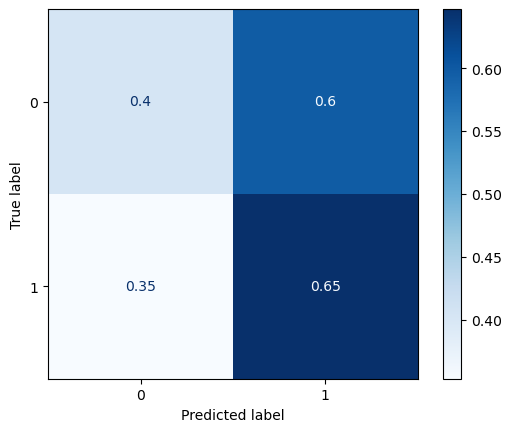

In [53]:
evaluate(y_hate, predictions_hate)

## VADER

In [42]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt

According to the academic paper on VADER, the Valence score is measured on a scale from -4 to +4, where -4 stands for the most 'Negative' sentiment and +4 for the most 'Positive' sentiment. Let's set the following ranges for defining the polarity of the text:

- From -4 to 0: Negative --> 0
- From 0 to 4: Positive --> 1

In [43]:
def apply_vader(data, threshold = 0, plot = True, evaluate = True):
    analyzer = SentimentIntensityAnalyzer()
    data['vader'] = data.apply(lambda x: analyzer.polarity_scores(x['text'])['compound'], axis=1)
    if plot: 
        fig, ax = plt.subplots(figsize =(5, 3))
        ax.hist(data['vader'])
        plt.show()
    if evaluate: 
        data['predicted_target']=data.apply(lambda x: 0 if x['vader'] <= threshold else 1, axis=1)
        accuracy = accuracy_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        f1 = f1_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        precision = precision_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        recall = recall_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        plot_confusion_matrix(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        print(f'Accuracy: {accuracy}')    
        print(f'F1: {f1}')   
        print(f'Precision: {precision}')    
        print(f'Recall: {recall}')  

### VADER on Sentiment Data

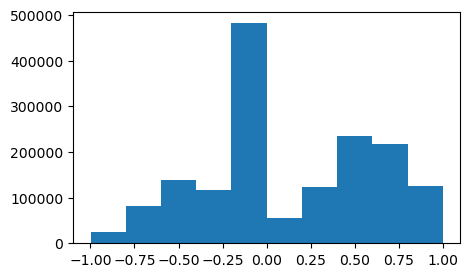

Accuracy: 0.6525475
F1: 0.6431759626901021
Precision: 0.6610046729588458
Recall: 0.62628375


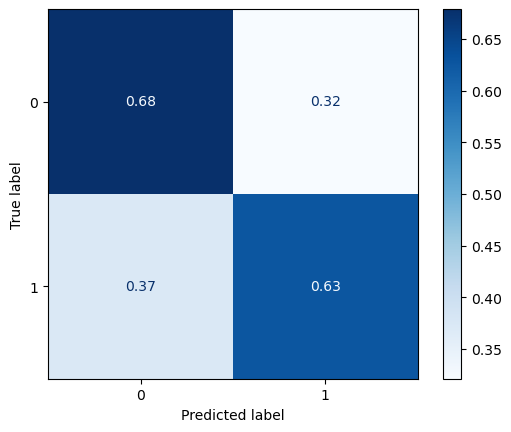

In [44]:
df_vader_sentiment = df_sentiment
apply_vader(df_vader_sentiment)

### VADER on Hate Speech Data

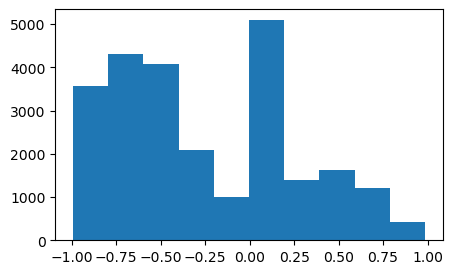

Accuracy: 0.7401041036194166
F1: 0.33823076132744273
Precision: 0.29551166965888687
Recall: 0.3953879413884218


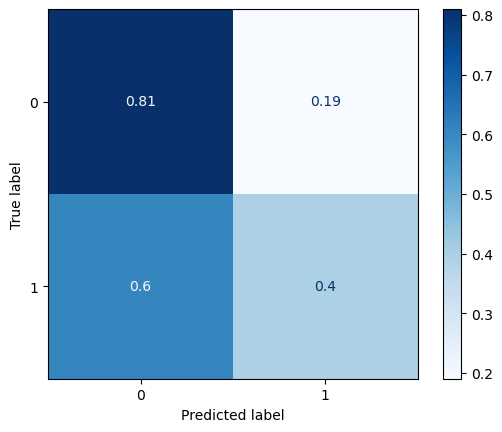

In [45]:
df_vader_hate = df_hate 
apply_vader(df_vader_hate)